# Train the model by preparing the dataset

In [15]:
%load_ext autoreload
%autoreload 2
import tensorflow as tf
import json
from src import preparedata
from src import modelarea
from src import trainarea

print(tf.__version__)
print(tf.config.list_physical_devices(
    device_type=None
))

params=json.load(open('params/params.json','r'))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2.10.1
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [16]:
#prepare data
dataset=preparedata.readGPDData(params['dataprepinargs'])
dataset.preparedata()

  0%|          | 0/31 [00:00<?, ?it/s]

In [17]:
#prepare model
landslidehazard=modelarea.lhmodel(params['modelparam'])
landslidehazard.preparemodel()

In [18]:
trainarea.trainmodel(landslidehazard.model,dataset.X_train,dataset.Y_train,params['trainparam'])
landslidehazard.model.save_weights('savedweights/final_modelfull_datav2.h5')

Epoch 1/100
21/24 [=========================>....] - ETA: 0s - loss: 28032202.0000 - gpdmetric: 596388.5000
Epoch 1: val_loss improved from inf to 17138754.00000, saving model to checkpoints/
INFO:tensorflow:Assets written to: checkpoints/assets
24/24 [==============================] - 7s 193ms/step - loss: 28134904.0000 - gpdmetric: 570710.3125 - val_loss: 17138754.0000 - val_gpdmetric: 430378.0000
Epoch 2/100
21/24 [=========================>....] - ETA: 0s - loss: 27071658.0000 - gpdmetric: 586392.1875
Epoch 2: val_loss improved from 17138754.00000 to 15876295.00000, saving model to checkpoints/
INFO:tensorflow:Assets written to: checkpoints/assets
24/24 [==============================] - 4s 166ms/step - loss: 27168814.0000 - gpdmetric: 560443.6875 - val_loss: 15876295.0000 - val_gpdmetric: 481289.6250
Epoch 3/100
21/24 [=========================>....] - ETA: 0s - loss: 26583996.0000 - gpdmetric: 585065.1250
Epoch 3: val_loss improved from 15876295.00000 to 15502240.00000, saving mo

In [5]:
landslidehazard.model.save_weights('savedweights/final_modelfull_datav2.h5')

In [29]:
landslidehazard.model.predict(dataset.X_train[:10,0])

AttributeError: 'readGPDData' object has no attribute 'X_train'

# validate by using QQ plot

In [3]:
%load_ext autoreload
%autoreload 2
import tensorflow as tf
import json
from src import preparedata
from src import modelarea
from src import trainarea
import tensorflow_probability as tfp
print(tf.__version__)
print(tf.config.list_physical_devices(
    device_type=None
))

params=json.load(open('params/params.json','r'))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2.10.1
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [4]:
#prepare data
dataset=preparedata.readGPDData(params['dataprepinargs'])
dataset.preparedata()
landslidehazard=modelarea.lhmodel(params['modelparam'])
landslidehazard.preparemodel()
landslidehazard.model.load_weights('savedweights/final_modelfull_datav2.h5')
trained_model=landslidehazard.model
gpd_params=trained_model.predict(dataset.X_train)
loc=0.0
scale=tf.math.exp(gpd_params[:,0])
conc=tf.nn.relu(gpd_params[:,1])
dists=tfp.distributions.GeneralizedPareto(loc=0,scale=scale,concentration=conc,validate_args=False,allow_nan_stats=False,name='GeneralizedExtremeValue') 




  0%|          | 0/31 [00:00<?, ?it/s]

864/864 [==============================] - 1s 1ms/step


AttributeError: 'GeneralizedPareto' object has no attribute 'quantiles'

In [5]:
#calculate theoritical quantiles
gpto=tfp.distributions.GeneralizedPareto(loc=0.,scale=0.5039473874727983,concentration=0.5856400905176868)
tquantiles=gpto.quantile(dataset.Y_train)
quantiles=dists.quantile(dataset.Y_train)

In [29]:
import numpy as np
a=dataset.Y_train
ttquantile=np.array([np.count_nonzero(a<x) / a.size for x in a])*100

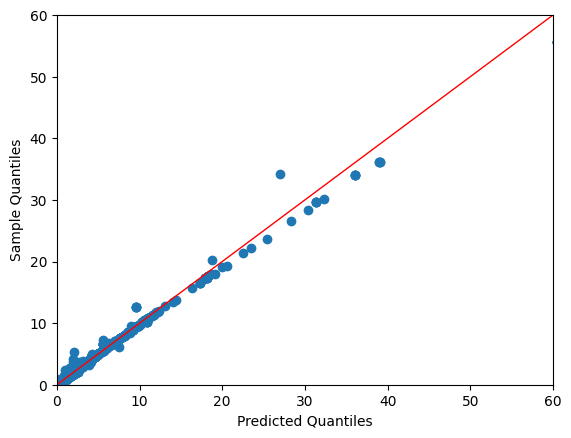

In [59]:
import matplotlib.pyplot as plt 
import seaborn as sns 
plt.scatter(quantiles,tquantiles)
plt.xlim(0,60)
plt.ylim(0,60)
plt.axline((0, 0), (1, 1), linewidth=1, color='r')
plt.xlabel('Predicted Quantiles')
plt.ylabel('Sample Quantiles')
plt.savefig('Data/Plots/qq.pdf',dpi=300)

# Perform inference by calculating landslide hazrd

In [1]:
%load_ext autoreload
%autoreload 2
import tensorflow as tf
import json
from src import preparedata
from src import modelarea
from src import inference
from src import savehazard

print(tf.__version__)
print(tf.config.list_physical_devices(
    device_type=None
))
params=json.load(open('params/params.json','r'))

2023-01-24 12:16:08.531386: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-24 12:16:08.731564: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-01-24 12:16:10.646364: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/dahala/miniconda3/envs/dlashok/lib/
2023-01-24 12:16:10.647264: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: lib

2.10.1
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [11]:
rp=20
dataset=preparedata.readGPDData(params['dataprepinargs'])
dataset.preparedatainference(rp)

  0%|          | 0/31 [00:00<?, ?it/s]

In [12]:
landslidehazard=modelarea.lhmodel(params['modelparam'])
landslidehazard.preparemodel()
haz=inference.inferenceLH(model=landslidehazard.model,model_weights='savedweights/final_modelfull_data.h5',xdata=dataset.Xinference,rp=rp)

2219/2219 [==============================] - 4s 2ms/step


In [13]:
savehazard.save_predicted_Haz(ids=dataset.InferenceID,prediction=haz,hazcol=f'haz_{rp}rp',sufile='Data/SlopeUnits/SlopeUnits_V3.shp',outfile=f'Data/Results/LsHaz{rp}_v2.shp')

In [14]:
haz.max()

0.22016518

In [15]:
haz.min()

0.11952155

In [12]:
import numpy as np 
np.exp(-1.7580993)

0.17237218046254701